# Урок 4. Метрики качества классификации ч.2

Продолжим работу с метриками классификации. В предыдущем задании мы разобрали матрицу ошибок и две основные метрики, которые используются при бинарной классификации.

Сейчас рассмотрим F-меру - совокупную метрику по precision и recall - и более сложную AUC-ROC.

### 2.1
Из задания к предыдущему уроку выберите классификатор, который давал наименьшее значение recall, вычислите для него precision, применив precision_score, и самостоятельно посчитайте F1-меру (расчеты должны присутствовать). Затем проверьте ответ, используя встроенную функцию.

Сравните полученную f1-меру со значением среднего арифметического полноты и точности.

In [1]:
import os
import pickle
import numpy as np
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

In [18]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
model = pickle.load(open('models/LogisticRegression.sav', 'rb'))

In [3]:
precision_score(y_test, model.predict(X_test))

0.7901234567901234

In [4]:
accuracy = accuracy_score(y_test, model.predict(X_test))
recall = recall_score(y_test, model.predict(X_test))
my_f1_score = 2 * accuracy * recall / (accuracy + recall)

print(my_f1_score)
f1_score(y_test, model.predict(X_test))


0.7434090315844426


0.7398843930635839

In [5]:
(accuracy + recall) / 2
# рассчитанная f1-мера и среднее арифметическое полноты и точности совпали до 2-го знака

0.7469292259699747

В библиотеке sklearn есть удобная функция classification_report, возвращающая precision, recall, F-меру и количество экземпляров каждого класса в удобном для чтения формате. Также существует функция precision_recall_fscore_support, возвращающая те же самые метрики, но в форме массива.

### 2.2
Для каждого классификатора из предыдущего урока рассчитайте и выведите следующие импортированные метрики.

In [6]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [7]:
names = [name[:-4] for name in os.listdir('models/')]
models = [pickle.load(open('models/' + model, 'rb')) for model in os.listdir('models/')]
classifiers = dict(zip(names, models))

for name, classifier in classifiers.items():
    print(name,
          classification_report(y_test, classifier.predict(X_test)),
          precision_recall_fscore_support(y_test, classifier.predict(X_test)),
          sep='\n', end='\n\n')



DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       131
           1       0.78      0.72      0.75        92

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223

(array([0.8115942 , 0.77647059]), array([0.85496183, 0.7173913 ]), array([0.83271375, 0.74576271]), array([131,  92], dtype=int64))

GaussianNB
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       131
           1       0.76      0.70      0.73        92

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223

(array([0.79856115, 0.76190476]), array([0.84732824, 0.69565217]), array([0.82222222, 0.72727273]), array([131,  92], dtype=int64))

KNeighborsClassifier
              precision  

Вернемся к классификатору LogisticRegression, который мы обучали в предыдущем задании. Там мы не затрагивали настройку гиперпараметров: сделать это можно с помощью LogisticRegressionCV - перебора параметров по сетке с последующей кросс-валидацией (по сути это аналог GridSearchCV, но со своими параметрами внутри, применимыми только к логистической регрессии). Этот класс создан специально для логистической регрессии, т.к. для нее известны эффективные алгоритмы перебора параметров.

У LogisticRegression есть гиперпараметр C - обратный коэффициент регуляризации. Не вдаваясь в подробное описание по формуле, можно сказать, что C соответствует "сложности" модели: чем больше C, тем более сложные зависимости может восстанавливать модель; если параметр C слишком мал (слишком сильная регуляризация), то модель окажется недообученной, а если наоборот регуляризация слишком слабая (т.е. C принимает большие значения), то скорее всего модель окажется переобученной, потому как модель будет слишком "бояться" ошибиться на обучающей выборке.

### 2.3 

1. Используя StratifiedKFold, разбейте данные для кросс-валидации по 5-ти блокам (не забывайте во всех методах использовать random_state=17).
2. С помощью numpy.logspace разбейте интервал (-1, 2) на 500 значений.
3. С помощью LogisticRegressionCV подберите оптимальный параметр C: установите гиперпараметр Cs равным объекту из п.2 (разбиение интервала (-1, 2) отвечает за подбор обратного коэффициента регуляризации C); cv равным объекту из п.1 (разбиение для кросс-валидации); scoring равным "roc_auc" (отвечает за оптимизацию гиперпараметров на кросс-валидации: метрика, установленная в scoring, контролирует, как оценивать модель при каждом из наборе параметров, т.е. показывает, какая метрика должна быть наилучшей).
4. Обучите полученную модель на тренировочных данных.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

In [40]:
skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)
C = np.logspace(-1, 2, 500)
log_reg_cv = LogisticRegressionCV(Cs=C, cv=skf, scoring='roc_auc')
log_reg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([  0.1       ,   0.10139395,   0.10280732,   0.1042404 ,
         0.10569346,   0.10716676,   0.10866061,   0.11017528,
         0.11171107,   0.11326826,   0.11484715,   0.11644806,
         0.11807128,   0.11971713,   0.12138593,   0.12307798,
         0.12479362,   0.12653318,   0.12829698,   0.13008537,
         0.13189869,   0.13373729,   0.13560151,   0.13749172,
         0.13940828,   0.14135156,   0.14332192,   0.14531975,
         0.14734543,   0.149399...
        72.73165113,  73.7454909 ,  74.77346305,  75.81576458,
        76.87259522,  77.9441575 ,  79.03065679,  80.13230128,
        81.24930211,  82.38187331,  83.53023195,  84.69459808,
        85.87519485,  87.07224849,  88.28598841,  89.51664721,
        90.76446073,  92.02966809,  93.31251175,  94.61323756,
        95.93209478,  97.26933615,  98.62521795, 100.        ]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     random_state=17, scoring='roc_auc')

### 2.4
Используя метод plot из matplotlib.pyplot, выведите график зависимости auc_roc от значения C.

*Примечание: значения по оси x - разбиение с помощью np.logspace из п.2 предыдущего задания, а значения по оси y - среднее значение roc_auc по каждой валидации, т.е. среднее значение из полученных на каждом из 5-ти разбиений при данном параметре C (используйте метод scores_ объекта, который инкапсулирует LogisticRegressionCV).*

In [28]:
import matplotlib.pyplot as plt

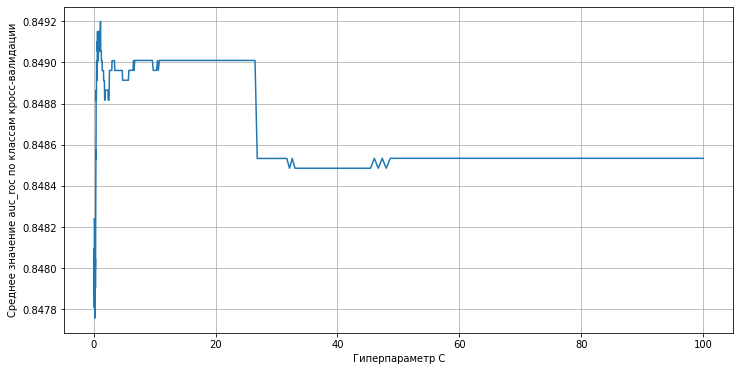

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(C, np.mean(log_reg_cv.scores_[1], axis=0))
ax.set_xlabel('Гиперпараметр С')
ax.set_ylabel('Среднее значение auc_roc по классам кросс-валидации')
plt.grid()
plt.show()


### 2.5
С помощью метода C_ того же объекта выведите лучшее значение C. Выведите более конкретную область графика (область ~15 точкам по x), включающую лучшее значение C.

*Примечание: используйте plt.xlim.*

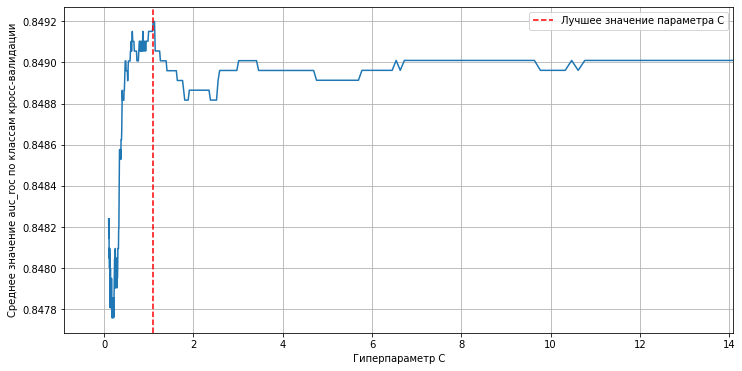

[1.0966806]


In [84]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(C, np.mean(log_reg_cv.scores_[1], axis=0))

ax.set_xlabel('Гиперпараметр С')
ax.set_ylabel('Среднее значение auc_roc по классам кросс-валидации')

plt.axvline(log_reg_cv.C_, linestyle='--', color='red', label=f'Лучшее значение параметра С')
plt.xlim(log_reg_cv.C_ - 2, log_reg_cv.C_ + 13)
plt.legend()
plt.grid()
plt.show()

print(log_reg_cv.C_)

### 2.6
С помощью метода predict_proba получите вероятности принадлежности объектов тестовой выборки к классам. Постройте график roc_auc для тестовой выборки и выведите значение auc.

**Пример** построения графика.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
probas = logit_search.fit(x_train, y_train).predict_proba(x_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)

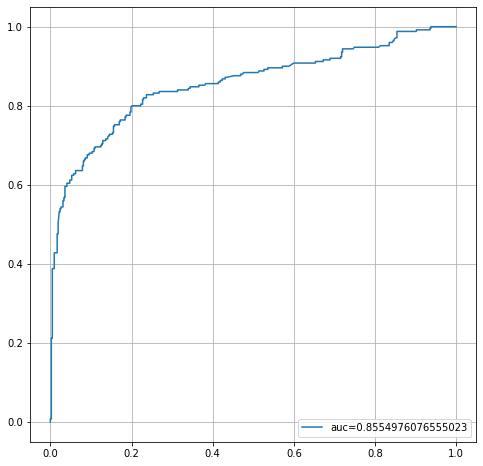

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))

probas = log_reg_cv.predict_proba(X_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)
plt.grid()
plt.show()